In [ ]:
# export OMP_NUM_THREADS=1

In [1]:
import qutip as qt
import numpy as np
import scqubits as scq
import matplotlib.pyplot as plt
import itertools
import warnings
import os
import time

In [2]:
levels = 6
fluxonium = scq.Fluxonium(EJ=8.9, EC=2.5, EL=0.5, flux=0.48, cutoff=110)
c_ops = None  # will be initialized once below

In [3]:
def init_c_ops():
    gamma_ij = {}
    for j in range(1, levels):
        for i in range(j):
            t1 = fluxonium.t1_capacitive(j, i, Q_cap=1e5, total=False)
            if t1 is not None and t1 > 0:
                rate = 1.0 / t1
                gamma_ij[(i, j)] = rate
                gamma_ij[(j, i)] = rate
    c_ops_local = []
    for (i, j), gamma in gamma_ij.items():
        cop = np.sqrt(gamma) * qt.basis(levels, i) * qt.basis(levels, j).dag()
        c_ops_local.append(cop)
    return c_ops_local

In [4]:
scq.settings.T1_DEFAULT_WARNING=False


if c_ops is None:
    c_ops = init_c_ops()

evals, evecs = fluxonium.eigensys(evals_count=levels)
n_op_energy_basis = qt.Qobj(fluxonium.process_op(fluxonium.n_operator(), energy_esys=(evals, evecs)))
H0 = qt.Qobj(np.diag(evals))
A = 0.1
drive_op = n_op_energy_basis
H = [H0, [A * drive_op, 'cos(wd * t)']]

See documentation for details.
This warning can be disabled by executing:
scqubits.settings.T1_DEFAULT_WARNING=False

 /home/stf/anaconda3/lib/python3.12/site-packages/scqubits/core/noise.py: 1213

In [5]:
def evolve(omega_d, t_g):
    # global c_ops
    # if c_ops is None:
    #     c_ops = init_c_ops()

    # evals, evecs = fluxonium.eigensys(evals_count=levels)
    # n_op_energy_basis = qt.Qobj(fluxonium.process_op(fluxonium.n_operator(), energy_esys=(evals, evecs)))
    # H0 = qt.Qobj(np.diag(evals))
    # A = 0.1
    # drive_op = n_op_energy_basis
    # H = [H0, [A * drive_op, 'cos(wd * t)']]
    args = {'wd': omega_d}
    options = qt.Options(nsteps=1000000, store_states=True, atol=1e-10, rtol=1e-9)

    propagator = qt.propagator(H, t_g, args=args, options=options, c_ops=c_ops)
    propagator_kraus = qt.to_kraus(propagator)
    propagator_2x2 = [qt.Qobj(k.full()[:2, :2]) for k in propagator_kraus]
    p_2x2_super = qt.kraus_to_super(propagator_2x2)
    fidelity = qt.average_gate_fidelity(p_2x2_super, qt.sigmax())
    print("completed iteration")
    return fidelity

def wrapped_evolve(args):
    return evolve(*args)


## Parallel Execution

In [6]:
from joblib import Parallel, delayed
from tqdm.notebook import tqdm  # Better in Jupyter

In [7]:
# if __name__ == "__main__":
#     evals, _ = fluxonium.eigensys(evals_count=levels)
#     omega_d_base = evals[1] - evals[0]

#     omega_d_array = np.linspace(omega_d_base - 0.005, omega_d_base + 0.005, 10)
#     peak_time_noise = 559.5559555955596  
#     t_g_array = np.linspace(0.99 * peak_time_noise, 1.01 * peak_time_noise, 10)
#     param_pairs = list(itertools.product(omega_d_array, t_g_array))
#     print(f"Total simulations to run: {len(param_pairs)}")

#     # Parallel execution using joblib
#     results_flat = Parallel(n_jobs=-1)(
#         delayed(evolve)(omega_d, t_g)
#         for (omega_d, t_g) in tqdm(param_pairs, desc="Running simulations")
#     )

#     results = np.reshape(results_flat, (len(omega_d_array), len(t_g_array)))

#     max_idx = np.unravel_index(np.argmax(results), results.shape)
#     max_value = results[max_idx]
#     omega_d_best = omega_d_array[max_idx[0]]
#     t_g_best = t_g_array[max_idx[1]]

#     print("\n=== Final Results ===")
#     print(f"Best fidelity: {max_value}")
#     print(f"Found at omega_d = {omega_d_best}, t_g = {t_g_best}")
#     print(f"Indices in results array: {max_idx}")

In [8]:
# results

### Param map rework for windows

In [9]:
def parallel_map_qutip(task, values, task_args=tuple(), task_kwargs={}, **kwargs):
    """
    ---
    peterg NOTE: This is a modified parallel_map taken from qutip's source
    code. The version I would typically use, can break on some code that uses
    qutip's internal routines. This is likely due to some conflict with the
    openmp code (which the code below "turns off" via an environmental
    variable).  My slight modification is to to allow pathos (assumed imported
    as "mp") module to be used, as it handles pickle'ing various fancy objects
    much better.
    ---


    Parallel execution of a mapping of `values` to the function `task`. This
    is functionally equivalent to::

        result = [task(value, *task_args, **task_kwargs) for value in values]

    Parameters
    ----------
    task : a Python function
        The function that is to be called for each value in ``task_vec``.
    values : array / list
        The list or array of values for which the ``task`` function is to be
        evaluated.
    task_args : list / dictionary
        The optional additional argument to the ``task`` function.
    task_kwargs : list / dictionary
        The optional additional keyword argument to the ``task`` function.
    progress_bar : ProgressBar
        Progress bar class instance for showing progress.

    Returns
    --------
    result : list
        The result list contains the value of
        ``task(value, *task_args, **task_kwargs)`` for
        each value in ``values``.

    """
    os.environ["QUTIP_IN_PARALLEL"] = "TRUE"
    kw = _default_kwargs()
    if "num_cpus" in kwargs:
        kw["num_cpus"] = kwargs["num_cpus"]
    
    kw["num_cpus"] = 7

    nfinished = [0]


    try:
        pool = mp.Pool(processes=kw["num_cpus"])

        async_res = [
            pool.apply_async(
                task, (value,) + task_args, task_kwargs
            )
            for value in values
        ]

        while not all([ar.ready() for ar in async_res]):
            for ar in async_res:
                ar.wait(timeout=0.1)

        pool.terminate()
        pool.join()

    except KeyboardInterrupt as e:
        os.environ["QUTIP_IN_PARALLEL"] = "FALSE"
        pool.terminate()
        pool.join()
        raise e

    os.environ["QUTIP_IN_PARALLEL"] = "FALSE"
    return [ar.get() for ar in async_res]


def varg_opt(data, axis=None, opt_fun=np.nanargmin):
    """
    Return an index of a (possibly) multi-dimensional array of the element that
    optimizes a given function along with the optimal value.
    """
    index = arg_opt(data, axis=axis, opt_fun=opt_fun)
    return index, data[index]

def parallel_map_adapter(f, iterable):
    return parallel_map_qutip(f, list(iterable))


In [10]:
def param_map(f, parameters, map_fun=map, dtype=object):

    dims_list = [len(i) for i in parameters]
    total_dim = np.prod(dims_list)
    parameters_prod = tuple(itertools.product(*parameters))

    data = np.empty(total_dim, dtype=dtype)
    # for i, d in enumerate(map_fun(f, parameters_prod)):
    #     data[i] = d
    for i, d in enumerate(map_fun(lambda args: f(*args), parameters_prod)):
        data[i] = d
    print("complete param map")
    return np.reshape(data, dims_list)

In [11]:
# def parallel_map_qutip_2(task, values, tas
# TypeError: wrapped_evolve() takes 1 positional argument but 2 were givenk_args=tuple(), task_kwargs={}, **kwargs):
#     os.environ["QUTIP_IN_PARALLEL"] = "TRUE"
#     kw = _default_kwargs()
#     if "num_cpus" in kwargs:
#         kw["num_cpus"] = kwargs["num_cpus"]

#     try:
#         pool = mp.Pool(processes=kw["num_cpus"])
#         async_res = [
#             pool.apply_async(
#                 task, (value,) + task_args, task_kwargs
#             )
#             for value in values
#         ]

#         # Collect results
#         results = [ar.get() for ar in async_res]

#         # Wait for all tasks to complete
#         start_time = time.time()
#         timeout_sec = 600  # Increased timeout for complex simulations
#         while not all([ar.ready() for ar in async_res]):
#             print(f"{sum(ar.ready() for ar in async_res)}/{len(async_res)} tasks completed...")
#             time.sleep(1)
#             if time.time() - start_time > timeout_sec:
#                 raise TimeoutError("parallel_map_qutip is hanging or a worker failed.")

#         pool.close()
#         pool.join()
#         os.environ["QUTIP_IN_PARALLEL"] = "FALSE"
#         return results

#     except KeyboardInterrupt as e:
#         os.environ["QUTIP_IN_PARALLEL"] = "FALSE"
#         pool.terminate()
#         pool.join()
#         raise e
#     except Exception as e:
#         os.environ["QUTIP_IN_PARALLEL"] = "FALSE"
#         pool.terminate()
#         pool.join()
#         raise e

In [23]:
evals, _ = fluxonium.eigensys(evals_count=levels)
omega_d_base = evals[1] - evals[0]

omega_d_array = np.linspace(omega_d_base - 0.001, omega_d_base + 0.001, 7)
peak_time_noise = 559.5559555955596  # previously determined
t_g_array = np.linspace(0.99 * peak_time_noise, 1.01 * peak_time_noise, 6)
# param_pairs = list(itertools.product(omega_d_array, t_g_array))

# print(f"Total simulations to run: {len(param_pairs)}")

warnings.filterwarnings(
    "ignore",
    module="qutip.*"  # Regex pattern to match all warnings from qutip
)
scq.settings.T1_DEFAULT_WARNING=False

try:
    import pathos.multiprocessing as mp
except ImportError:
    print(
        "using std lib version of multiprocessing; consider installing pathos; it's much more robust"
    )
    import multiprocessing as mp

def _default_kwargs():
    return {"num_cpus": os.cpu_count() or 1}

#single process
# fidelity_results = param_map(evolve, [omega_d_array, t_g_array])



#parallel process
# fidelity_results = param_map(evolve, [omega_d_array, t_g_array], map_fun=parallel_map_qutip)

In [13]:
# fidelity_results = param_map(evolve, [omega_d_array, t_g_array])

In [24]:
fidelity_results = param_map(evolve, [omega_d_array, t_g_array], map_fun=parallel_map_qutip)

completed iteration
completed iteration
completed iteration
completed iteration
completed iteration
completed iteration
completed iteration
completed iteration
completed iteration
completed iteration
completed iteration
completed iteration
completed iteration
completed iteration
completed iteration
completed iteration
completed iteration
completed iteration
completed iteration
completed iteration
completed iteration
completed iteration
completed iteration
completed iteration
completed iteration
completed iteration
completed iteration
completed iteration
completed iteration
completed iteration
completed iteration
completed iteration
completed iteration
completed iteration
completed iteration
completed iteration
completed iteration
completed iterationcompleted iteration

completed iteration
completed iteration
completed iteration
complete param map


In [25]:
fidelity_results

array([[0.34916995103364007, 0.4152144211630617, 0.6545144196737788,
        0.7883837399196197, 0.6597230057327971, 0.41938561555095727],
       [0.340937263976321, 0.45046416057637256, 0.6965610342817686,
        0.792139024960743, 0.6248450657044459, 0.3907661786147445],
       [0.34023766085205964, 0.4898845002408149, 0.7326103500227216,
        0.7848836181242541, 0.5850106051574104, 0.36729995034501356],
       [0.3473323334660181, 0.5314762585765883, 0.7606915336166401,
        0.7669793343826316, 0.5424721463958156, 0.3505059820803163],
       [0.3619092843175385, 0.5730044473527692, 0.7792690708596943,
        0.7394094491440839, 0.4995990876253226, 0.34139292432325624],
       [0.38310132464244306, 0.6121629210306282, 0.7873558087667515,
        0.7037054937046804, 0.4587024670615813, 0.34037882591448554],
       [0.40954997897809564, 0.6467464212324151, 0.7845821380793115,
        0.6618320808813497, 0.42186585874078003, 0.34726071083046395]],
      dtype=object)

In [16]:
# Q_cap

# log scale q_scale as well as fidelity (1-f = error)

# heat map for t and w

--------------

In [26]:
def density(
    z,
    x_array,
    y_array,
    x_label=None,
    y_label=None,
    data_label=None,
    title=None,
    fig_ax=None,
    process_fun=None,
    z_min_max=None,
    norm_fun=None,
    show_values=False,
    **kwargs,
):
    """
    norm_fun should typically be: lambda (z_min, z_max): SymLogNorm(1e-9, 1.0, vmin=z_min, vmax=z_max)
    with: from matplotlib.colors import LogNorm, SymLogNorm
    """
    global global_fig, global_axes
 
    fig, ax = fig_ax or plt.subplots(1, 1, 
            # figsize=(14,12)
            )
    global_fig, global_axes = fig, ax
 
    x, y = np.meshgrid(x_array, y_array)
 
    z = np.ma.array(z)
 
    if process_fun is not None:
        z = process_fun(z)
 
    if z_min_max is not None and not callable(z_min_max):
        z_min = np.nanmin(z) if z_min_max[0] is None else z_min_max[0]
        z_max = np.nanmax(z) if z_min_max[1] is None else z_min_max[1]
    else:
        z_min, z_max = np.nanmin(z), np.nanmax(z)
 
    print(z_min, z_max)
 
    norm = None
    if norm_fun is not None:
        norm = norm_fun(z_min, z_max)
        z_min, z_max = None, None
 
    # extent=[x_array[0], x_array[-1], y_array[0], y_array[-1]]
    # im = ax.imshow(z.T,
    # interpolation=None,
    # cmap="jet",
    # origin='lower',
    # vmin=z_min, vmax=z_max,
    # # extent=extent,
    # aspect='auto',
    # **kwargs
    # )
 
    im = ax.pcolormesh(
        x_array,
        y_array,
        z.T,
        cmap="jet",
        vmin=z_min,
        vmax=z_max,
        norm=norm,
        shading="auto",
        **kwargs,
    )
 
    c1 = fig.colorbar(im, ax=ax)
    c1.ax.set_title(data_label, fontsize=12)
 
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
 
    ax.set_title(title)
 
    return fig, ax

0.34023766085205964 0.792139024960743


(<Figure size 640x480 with 2 Axes>, <Axes: >)

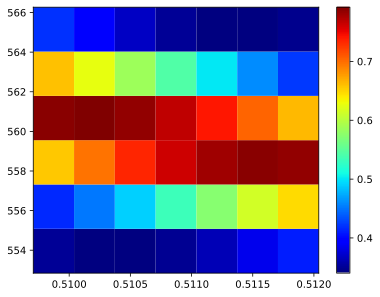

In [27]:
fidelity_results = np.asarray(fidelity_results,dtype = float)

density(fidelity_results, omega_d_array, t_g_array)

-------------------------